# Table of Contents
* [Load data](#Load-data)
	* [paths and reads](#paths-and-reads)
	* [extracting specifics](#extracting-specifics)
* [Basic question types](#Basic-question-types)
* [Non-Diagram Questions](#Non-Diagram-Questions)
	* [bigram/trigram question phrases](#bigram/trigram-question-phrases)
	* [question length](#question-length)
	* [looking at all/some/none of the above questions](#looking-at-all/some/none-of-the-above-questions)
	* [Looking for answer text in associated lessons](#Looking-for-answer-text-in-associated-lessons)
	* [hide](#hide)
* [Templates](#Templates)


In [356]:
%%capture
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

import json
import enchant
import pickle
import glob

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.stem.wordnet import WordNetLemmatizer

import language_check

import jsonschema
# from pdfextraction.ck12_new_schema import ck12_schema
from tqa_utils import Evaluator
from tqa_utils.render_html import render_sample_question_and_lesson
from analysis_utils import *

In [357]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light bright
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Load data

## paths and reads

In [3]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta6/'
file_name = 'tqa_dataset_beta7_5.json'
data_file =  dataset_root_dir + file_name

quest_evaluator = Evaluator(data_file)

In [4]:
with open(os.path.join(dataset_root_dir, file_name), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)
ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

## extracting specifics

In [5]:
lesson_text = collect_filtered_lesson_text(ck12_combined_dataset, True, True)

In [6]:
sum([len(sent_tokenize(text)) for text in lesson_text.values()])

78330

In [7]:
count_textbook_images(ck12_combined_dataset)

2156

In [8]:
all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
mc_questions = quest_evaluator.build_questions_by_subtype(all_ndqs)['Multiple Choice']
all_diagram_qs = quest_evaluator.build_question_lookup(by_type=True)['diagramQuestions']

# Basic question types

In [452]:
combined_topics = [lesson['lessonName'] for lesson in ck12_combined_dataset]
topic_series = pd.Series(combined_topics).value_counts()

In [453]:
# topic_series[:20]
len(combined_topics)

1076

In [454]:
q_types = []
for lesson in ck12_combined_dataset:
    for question in lesson['questions']['nonDiagramQuestions'].values():
        q_types.append(question['questionSubType'])
question_counts = pd.Series(q_types).value_counts()
print('total number of questions = ' + str(question_counts.sum()))
question_counts

total number of questions = 18929


Multiple Choice      6582
True or False        5400
Fill in the Blank    3643
Matching             1711
Short Answer         1593
dtype: int64

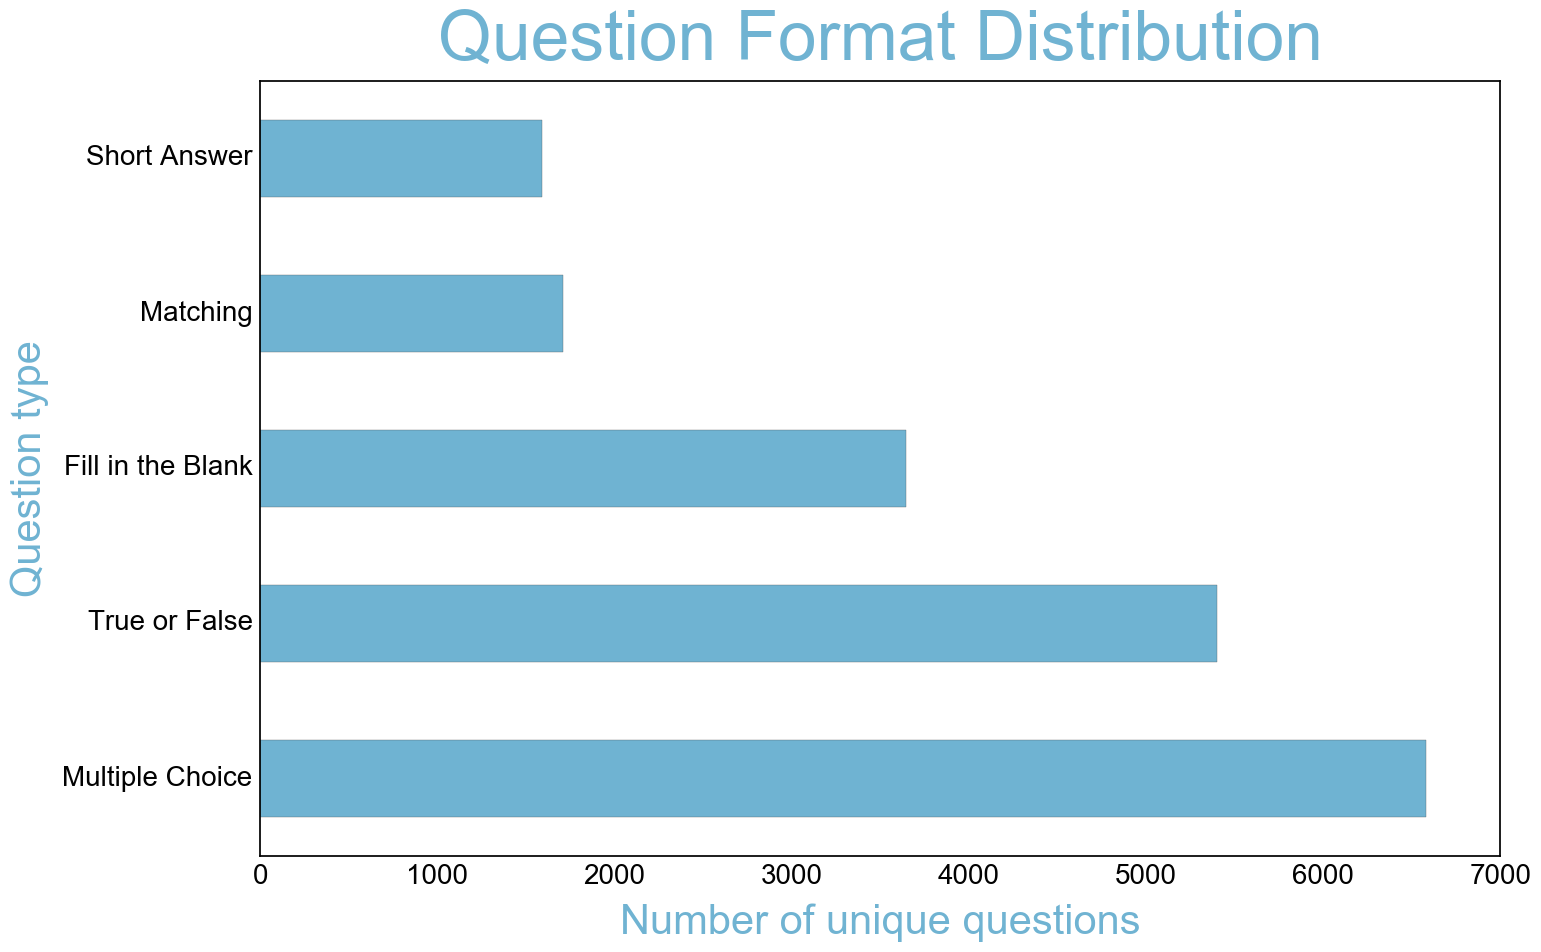

In [455]:
_ = question_counts.plot(kind="barh")
plt.title('Question Format Distribution', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Question type", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Number of unique questions", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [935]:
13693 + 12567

26260

In [933]:
question_counts

Multiple Choice      6582
True or False        5400
Fill in the Blank    3643
Matching             1711
Short Answer         1593
dtype: int64

In [10]:
usable_questions = question_counts[:2].append(question_counts[3:4])

In [11]:
sum(usable_questions)

13693

# Non-Diagram Questions

## bigram/trigram question phrases

In [555]:
cached_sw = ['?', 'the', 'a', 's', "'", 'this', '.', ',', '_____', '__________', 'an']

In [556]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

### first pass

In [557]:
ndq_corpus = ''
for lesson in ck12_combined_dataset:
    for qid, quest in lesson['questions']['nonDiagramQuestions'].items():
        ndq_corpus += ' ' + quest['beingAsked']['processedText'].replace('(', ' ').replace(')', ' ')
        
q_tokens = wordpunct_tokenize(ndq_corpus)
normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in q_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
    
qw_freq_d = nltk.FreqDist(normalized_tokens)
most_common_qw = qw_freq_d.most_common(20)

In [558]:
most_common_qw

[('of', 8740),
 ('is', 6556),
 ('in', 4303),
 ('to', 3415),
 ('that', 2788),
 ('are', 2578),
 ('and', 2267),
 ('which', 1691),
 ('what', 1540),
 ('by', 1214),
 ('energy', 1064),
 ('on', 1029),
 ('from', 1011),
 ('water', 987),
 ('can', 972),
 ('for', 948),
 ('when', 944),
 ('called', 892),
 ('with', 868),
 ('it', 856)]

In [10]:
print([word[0] for word in most_common_qw])

['of', 'is', 'in', 'to', 'that', 'are', 'and', 'which', 'what', 'by', 'energy', 'on', 'from', 'water', 'can', 'for', 'when', 'called', 'with', 'it']


In [465]:
phrase_bi_finder = BigramCollocationFinder.from_words(normalized_tokens)
phrase_bi_finder.apply_freq_filter(75) 
# phrase_bi_finder.nbest(bigram_measures.pmi, 10)
most_common_bigrams = []

for k,v in sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]:
    most_common_bigrams.append((' '.join(k), v))

In [466]:
sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]

[(('what', 'is'), 651),
 (('which', 'of'), 491),
 (('is', 'called'), 488),
 (('of', 'following'), 472),
 (('type', 'of'), 387),
 (('that', 'is'), 291),
 (('can', 'be'), 281),
 (('example', 'of'), 271),
 (('in', 'which'), 262),
 (('it', 'is'), 207),
 (('which', 'statement'), 196),
 (('amount', 'of'), 186),
 (('used', 'to'), 174),
 (('part', 'of'), 173),
 (('called', 'n'), 169)]

In [467]:
most_common_bigrams

[('what is', 651),
 ('which of', 491),
 ('is called', 488),
 ('of following', 472),
 ('type of', 387),
 ('that is', 291),
 ('can be', 281),
 ('example of', 271),
 ('in which', 262),
 ('it is', 207),
 ('which statement', 196),
 ('amount of', 186),
 ('used to', 174),
 ('part of', 173),
 ('called n', 169)]

In [470]:
phrase_tri_finder = TrigramCollocationFinder.from_words(normalized_tokens)
phrase_tri_finder.apply_freq_filter(30) 
# phrase_tri_finder.nbest(trigram_measures.pmi, 20)  

most_common_tri = []
three_word_qtypes = []
for k,v in sorted(phrase_tri_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:9]:
    most_common_tri.append((' '.join(k), v))
    three_word_qtypes.append(' '.join(k))

In [45]:
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 42] ## three word
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 375] ## two word

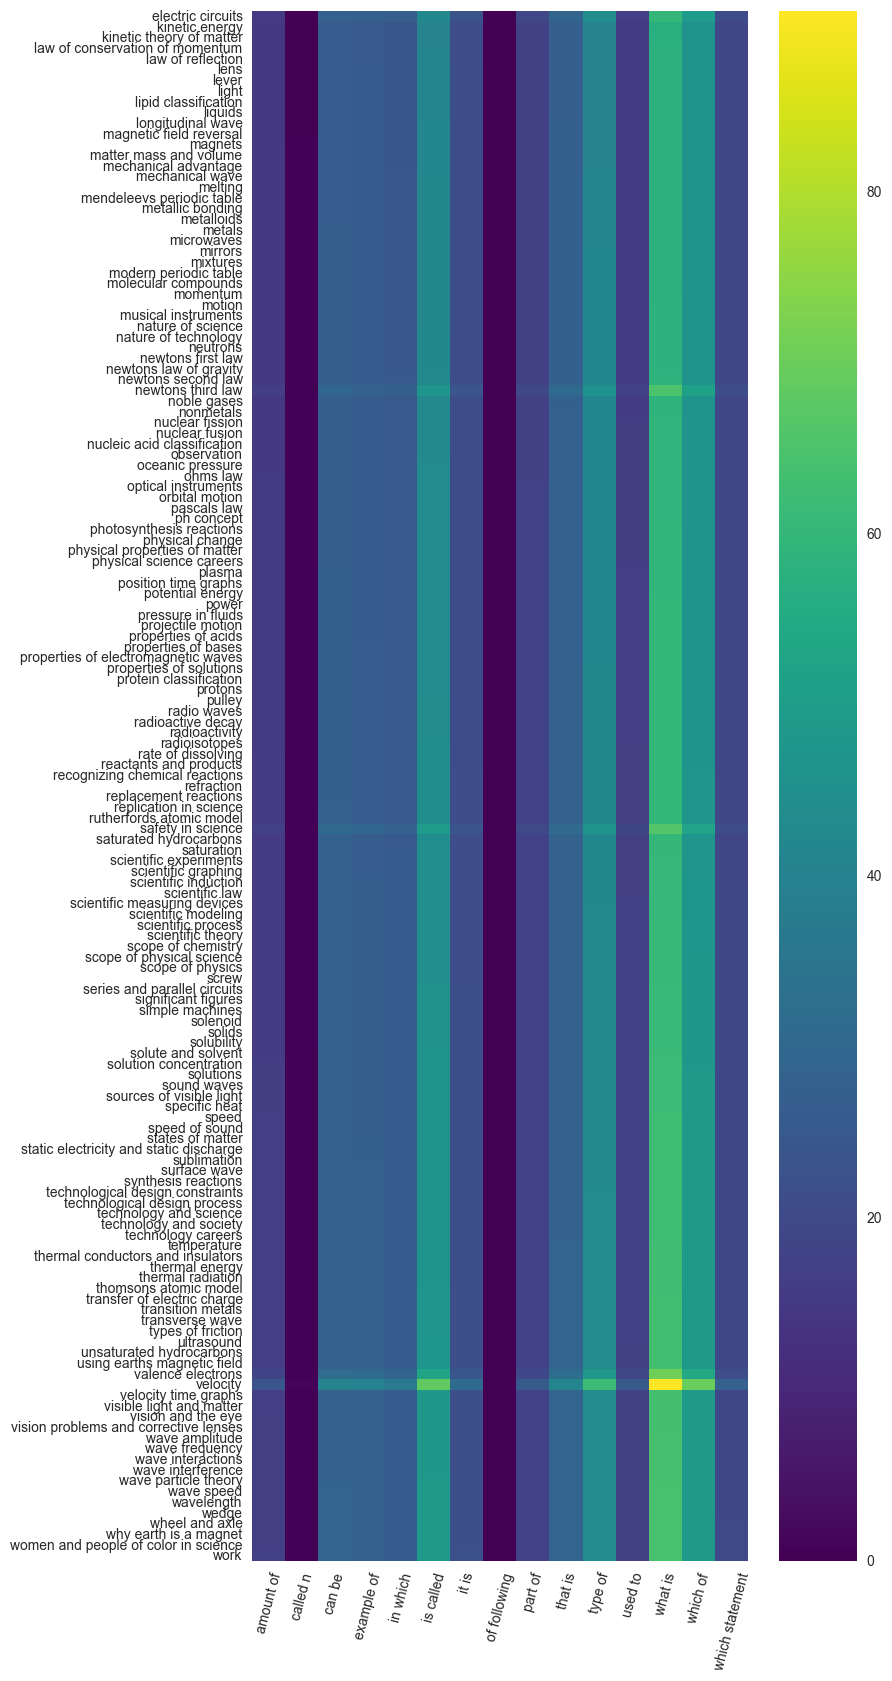

In [47]:
fig, ax = plt.subplots(figsize=(8, 20))
_ = sns.heatmap(high_values_lessons, cmap='viridis', robust=False)
_ = plt.xticks(rotation=75) 

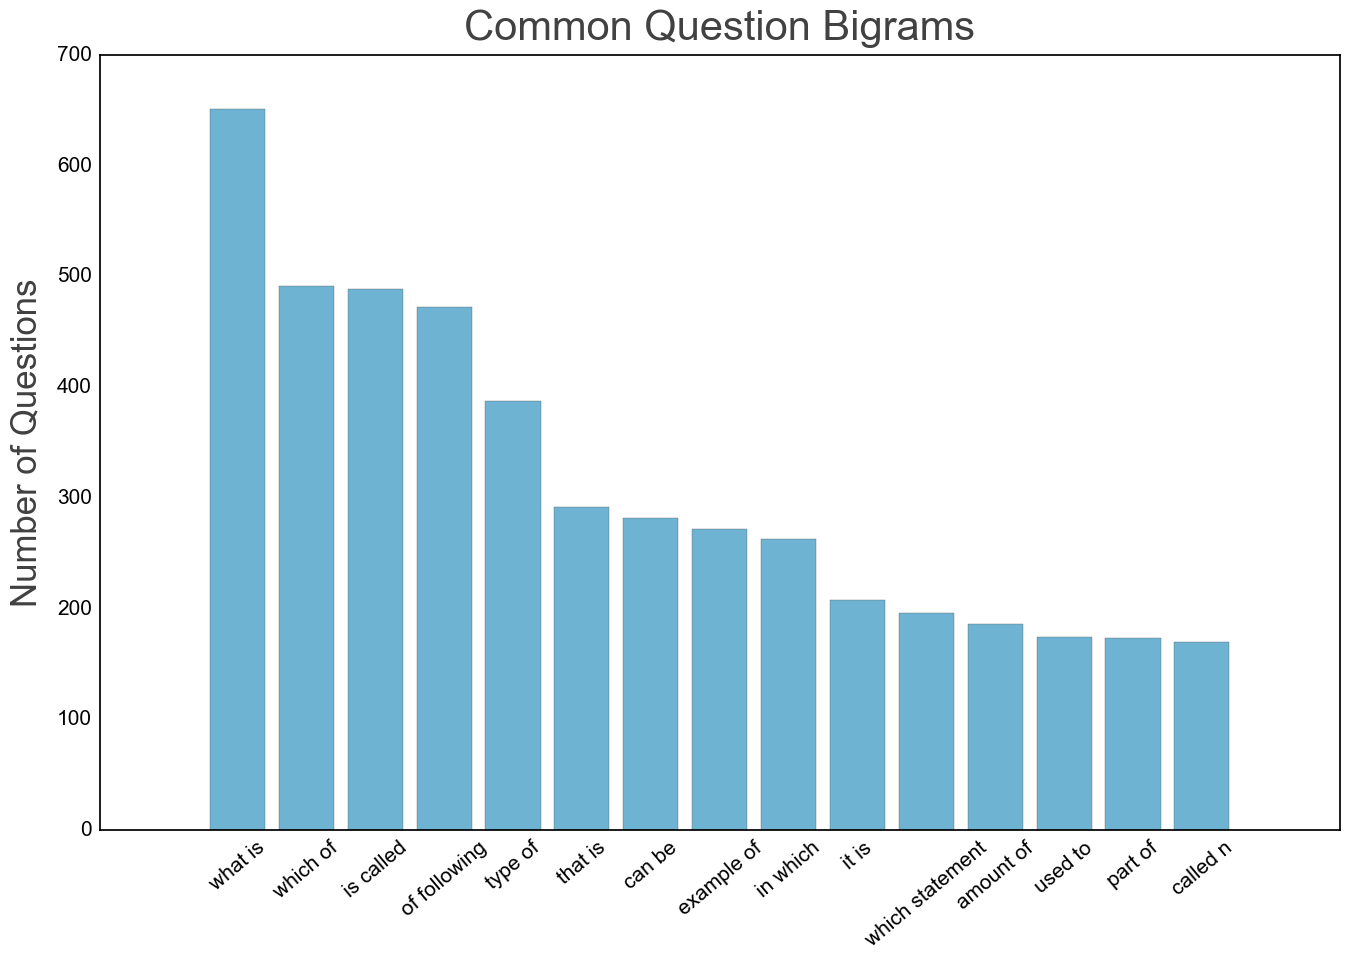

In [468]:
sorted_common = sorted(most_common_bigrams, key=lambda x: x[1], reverse=True) 

qtype = list(zip(*sorted_common))[0]
q_num = list(zip(*sorted_common))[1]
x_pos = np.arange(len(qtype))

plot_to_save = plt.bar(x_pos, q_num,align='center')
plt.xticks(x_pos, qtype, rotation=40) 

fig_labels = {
    'fig_title': 'Common Question Bigrams', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

# weights = np.ones_like(array_to_hist)/len(array_to_hist)
# tick_labels = plot_to_save.get_yticks()
# plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [572]:
all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
question_text = make_prop_series(all_ndqs, lambda x: x['beingAsked']['processedText'])
questions_sw_removed = {}
for qid, quest in all_ndqs.items():
    quest_text = quest['beingAsked']['processedText']
    quest['beingAsked']['processedText'] = ' '.join(tokenize_text(quest_text))
    questions_sw_removed[qid] = quest

In [505]:
most_common_tri

[('which of following', 392),
 ('of following is', 162),
 ('is example of', 158),
 ('is called n', 137),
 ('which statement about', 114),
 ('which of these', 89),
 ('is known as', 76),
 ('all of following', 75),
 ('process in which', 68)]

In [504]:
most_common_bigrams

[('what is', 651),
 ('which of', 491),
 ('is called', 488),
 ('of following', 472),
 ('type of', 387),
 ('that is', 291),
 ('can be', 281),
 ('example of', 271),
 ('in which', 262),
 ('it is', 207),
 ('which statement', 196),
 ('amount of', 186),
 ('used to', 174),
 ('part of', 173),
 ('called n', 169)]

In [512]:
common_answers_to_common_questions = defaultdict(list)
for qid, question in questions_sw_removed.items():
    for phrase in most_common_bigrams:
        if phrase[0] in question['beingAsked']['processedText']:
            answer_id = question['correctAnswer']['processedText']
            if answer_id not in question['answerChoices'].keys():
                continue
            answer_text = question['answerChoices'][answer_id]['processedText']
            answer_text_cleaned = ' '.join(tokenize_question(answer_text))
            if 'the above' not in answer_text:
                common_answers_to_common_questions[phrase[0]].append(answer_text)

In [513]:
for phrase, answer_series in common_answers_to_common_questions.items():
    answer_series = pd.Series(answer_series)
    print(phrase)
    print(answer_series.value_counts()[:5])
    print()

that is
false                   18
true                    17
carbon dioxide           3
control                  3
independent variable     3
dtype: int64

can be
true                 71
false                34
genital warts         3
hypothesis            2
carrying capacity     2
dtype: int64

it is
false                  41
true                   36
scientific theory       2
dependent variable      2
autosomal recessive     2
dtype: int64

called n
false                                              3
The poles line up with Earths north-south axis.    1
significant figures.                               1
dtype: int64

amount of
true       31
false      20
density     4
mass        2
volume      2
dtype: int64

what is
2         4
oxygen    2
0%        2
0         2
true      2
dtype: int64

example of
true                      36
false                     33
water                      3
Down syndrome              2
allopatric speciation.     2
dtype: int64

of following
water      

### second pass look only at start of last sentence

In [706]:
seven_ww = ['what', 'where', 'when', 'who', 'why', 'how', 'which']

## question length

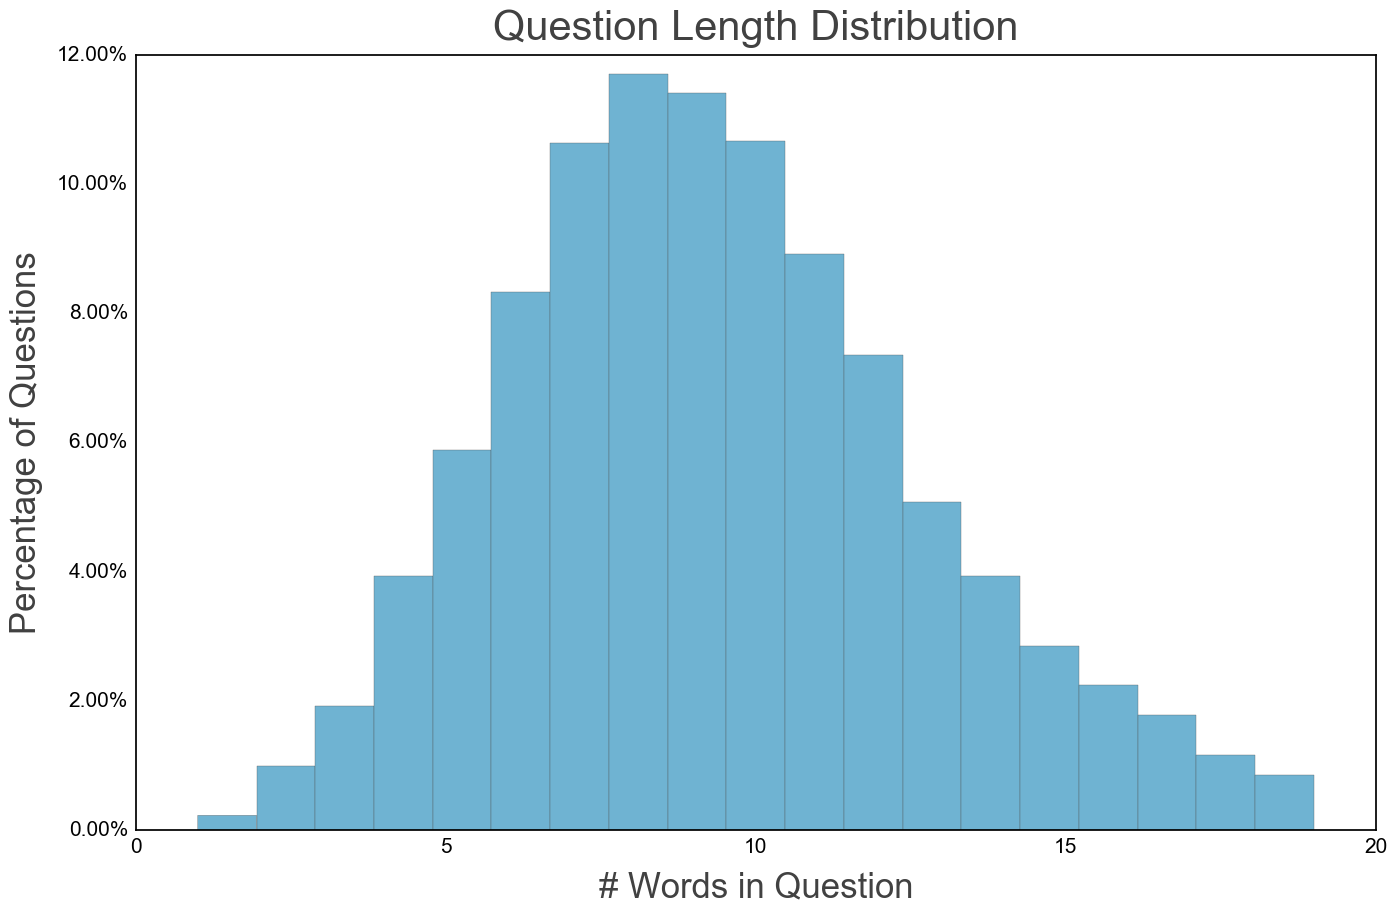

In [547]:
question_lengths = make_prop_series(all_ndqs, lambda x: len(x['beingAsked']['processedText'].split()))
question_lengths = question_lengths[question_lengths < 20]

fig_labels = {
    'fig_title': 'Question Length Distribution', 
    'x_label': '# Words in Question',
    'y_label': 'Percentage of Questions'
}
weights = np.ones_like(question_lengths)/len(question_lengths)
plot_to_save = question_lengths.hist(bins= 19, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [716]:
sum([len(sent_tokenize(text)) for text in lesson_text.values()])

48138

In [906]:
len(all_diagram_qs)

12567

## looking at all/some/none of the above questions

In [253]:
reasoning_q_phrases = [' if ', 'what would ', 'what happens']
reasoning_questions = collect_filtered_question_text(all_ndqs, reasoning_q_phrases)

In [125]:
question_asks = {}
answer_choices_with_above = []
correct_answer_choices_with_above = []
for qid, question in mc_questions.items(): 
    question_text = question['beingAsked']['processedText']
    ans_choices = {acid: ac['processedText'] for acid, ac in question['answerChoices'].items() if 'the above' in ac['processedText'].lower()}
    if ans_choices:
        above_choice_correct = 'd' == question['correctAnswer']['processedText']
        correct_answer_choices_with_above.append(above_choice_correct)
    answer_choices_with_above += list(ans_choices.values())
    question_asks[qid] = question_text

sum(correct_answer_choices_with_above) / len(answer_choices_with_above)

len(answer_choices_with_above)

## Looking for answer text in associated lessons

In [78]:
punct_stop = list(string.punctuation)
cached_sw = stopwords.words("english") + punct_stop + list(['_____', '__________'])
lmtizer = WordNetLemmatizer()
tokenizer = wordpunct_tokenize

def filter_pos(token_list):
    tagged_tokens = nltk.pos_tag(token_list)
    filtered_tokes = [toke[0] for toke in tagged_tokens if toke[1] in ['NN', 'RB', 'NNS', 'JJ']]
    if filtered_tokes:
        return filtered_tokes
    else:
        return []

def lemmatize_and_filter_sw(tokens):
    return filter_pos([lmtizer.lemmatize(toke) for toke in wordpunct_tokenize(tokens) if toke not in cached_sw])

In [79]:
vocab_topics = ['Lesson Vocabulary', 'Vocabulary']
structural_topics = ['Summary', 'Review', 'References', 'Explore More', 'Lesson Summary', 'Lesson Objectives',
                     'Points to Consider', 'Introduction', 'Recall', 'Apply Concepts', 'Think Critically', 'Resources',
                     'Explore More II', 'Explore More I', 'Explore More III']
ignore_topics = vocab_topics + structural_topics

In [80]:
answer_choice_idxs = make_prop_series(all_ndqs, lambda x:x['correctAnswer']['processedText'])

In [81]:
lesson_text_lookup = {}
for lesson in ck12_combined_dataset:
    lesson_text = ' '.join([topic['content']['text'] for topic_name, topic in sorted(lesson['topics'].items(), key=lambda x:x[1]['globalID']) if topic_name not in ignore_topics])
    lesson_text_lookup[lesson['globalID']] = [lmtizer.lemmatize(toke).lower() for toke in wordpunct_tokenize(lesson_text) if toke not in punct_stop]

In [82]:
list(lesson_text_lookup.items())[50]

('L_0573',
 ['many',
  'animal',
  'behavior',
  'are',
  'way',
  'that',
  'animal',
  'act',
  'naturally',
  'they',
  'dont',
  'have',
  'to',
  'learn',
  'how',
  'to',
  'behave',
  'in',
  'these',
  'way',
  'cats',
  'are',
  'natural',
  'born',
  'hunter',
  'they',
  'dont',
  'need',
  'to',
  'learn',
  'how',
  'to',
  'hunt',
  'spiders',
  'spin',
  'their',
  'complex',
  'web',
  'without',
  'learning',
  'how',
  'to',
  'do',
  'it',
  'from',
  'other',
  'spider',
  'birds',
  'and',
  'wasp',
  'know',
  'how',
  'to',
  'build',
  'nest',
  'without',
  'being',
  'taught',
  'these',
  'behavior',
  'are',
  'called',
  'innate',
  'an',
  'innate',
  'behavior',
  'is',
  'any',
  'behavior',
  'that',
  'occurs',
  'naturally',
  'in',
  'all',
  'animal',
  'of',
  'a',
  'given',
  'specie',
  'an',
  'innate',
  'behavior',
  'is',
  'also',
  'called',
  'an',
  'instinct',
  'the',
  'first',
  'time',
  'an',
  'animal',
  'performs',
  'an',
  'in

In [83]:
question_text_lookup = {}
for lesson in ck12_combined_dataset:
    question_text_lookup[lesson['globalID']] = defaultdict(dict)
    for qid, question in lesson['questions']['nonDiagramQuestions'].items():
        if question['questionSubType'] != 'Multiple Choice':
            continue
        correct_answer_idx = question['correctAnswer']['processedText']
        if correct_answer_idx not in question['answerChoices'].keys():
            continue
        ans_choices_text = ''
        for ac_text in question['answerChoices'].values():
            ans_choices_text += ac_text['processedText'] + ' '
#         correct_answer_text = question['answerChoices'][correct_answer_idx]['processedText']
        question_asked = question['beingAsked']['processedText']
        question_text_lookup[lesson['globalID']][qid]= ' '.join([question_asked, ans_choices_text])

In [84]:
# list(question_text_lookup.items())[531]

In [85]:
%%time
question_tokens = {lid: {qid: set(lemmatize_and_filter_sw(q_text)) for qid, q_text in questions.items()} for lid, questions in question_text_lookup.items()}

CPU times: user 8.5 s, sys: 136 ms, total: 8.63 s
Wall time: 8.66 s


In [86]:
tlid, tqt = list(question_tokens.items())[531]
tlt = lesson_text_lookup[tlid]

stqt = list(tqt.values())[0]

In [87]:
def compute_question_spread(lesson_text_array, question_tokens):
    oo_lesson_words = []
    q_toke_positions = []
    for token in question_tokens:
        if token not in lesson_text_array:
            pass
#             print(token)
        else:
            q_toke_positions.append(lesson_text_array.index(token))
    if q_toke_positions:
        return max(q_toke_positions) - min(q_toke_positions)

In [88]:
compute_question_spread(tlt, stqt)

214

In [89]:
question_dist_measure = {}
for l_id, lesson_text in lesson_text_lookup.items():
    for qid, question_tokes in question_tokens[l_id].items():
        q_dist = compute_question_spread(lesson_text, question_tokes)
        if q_dist:
            question_dist_measure[qid] = q_dist

In [90]:
len(mc_questions)

6582

In [91]:
len(q_dist_series)

NameError: name 'q_dist_series' is not defined

In [ ]:
q_dist_series = pd.Series(list(question_dist_measure.values()))

In [ ]:
fig_labels = {
    'fig_title': 'Simple Question Spread Metric', 
    'x_label': 'Number of words in lesson question spans',
    'y_label': 'Percentage of Questions'
}

array_to_hist = q_dist_series
weights = np.ones_like(array_to_hist)/len(array_to_hist)
plot_to_save = array_to_hist.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [92]:
%%javascript
require(['d3'], function(d3){
    
var diameter = 960,
    radius = diameter / 2,
    innerRadius = radius - 120;

var cluster = d3.layout.cluster()
    .size([360, innerRadius])
    .sort(null)
    .value(function(d) { return d.size; });

var bundle = d3.layout.bundle();

var line = d3.svg.line.radial()
    .interpolate("bundle")
    .tension(.85)
    .radius(function(d) { return d.y; })
    .angle(function(d) { return d.x / 180 * Math.PI; });

var svg = d3.select("body").append("svg")
    .attr("width", diameter)
    .attr("height", diameter)
  .append("g")
    .attr("transform", "translate(" + radius + "," + radius + ")");

var link = svg.append("g").selectAll(".link"),
    node = svg.append("g").selectAll(".node");

d3.json("files/readme-flare-imports.json", function(error, classes) {
  if (error) throw error;

  var nodes = cluster.nodes(packageHierarchy(classes)),
      links = packageImports(nodes);

  link = link
      .data(bundle(links))
    .enter().append("path")
      .each(function(d) { d.source = d[0], d.target = d[d.length - 1]; })
      .attr("class", "link")
      .attr("d", line);

  node = node
      .data(nodes.filter(function(n) { return !n.children; }))
    .enter().append("text")
      .attr("class", "node")
      .attr("dy", ".31em")
      .attr("transform", function(d) { return "rotate(" + (d.x - 90) + ")translate(" + (d.y + 8) + ",0)" + (d.x < 180 ? "" : "rotate(180)"); })
      .style("text-anchor", function(d) { return d.x < 180 ? "start" : "end"; })
      .text(function(d) { return d.key; })
      .on("mouseover", mouseovered)
      .on("mouseout", mouseouted);
});

function mouseovered(d) {
  node
      .each(function(n) { n.target = n.source = false; });

  link
      .classed("link--target", function(l) { if (l.target === d) return l.source.source = true; })
      .classed("link--source", function(l) { if (l.source === d) return l.target.target = true; })
    .filter(function(l) { return l.target === d || l.source === d; })
      .each(function() { this.parentNode.appendChild(this); });

  node
      .classed("node--target", function(n) { return n.target; })
      .classed("node--source", function(n) { return n.source; });
}

function mouseouted(d) {
  link
      .classed("link--target", false)
      .classed("link--source", false);

  node
      .classed("node--target", false)
      .classed("node--source", false);
}

d3.select(self.frameElement).style("height", diameter + "px");

// Lazily construct the package hierarchy from class names.
function packageHierarchy(classes) {
  var map = {};

  function find(name, data) {
    var node = map[name], i;
    if (!node) {
      node = map[name] = data || {name: name, children: []};
      if (name.length) {
        node.parent = find(name.substring(0, i = name.lastIndexOf(".")));
        node.parent.children.push(node);
        node.key = name.substring(i + 1);
      }
    }
    return node;
  }

  classes.forEach(function(d) {
    find(d.name, d);
  });

  return map[""];
}

// Return a list of imports for the given array of nodes.
function packageImports(nodes) {
  var map = {},
      imports = [];

  // Compute a map from name to node.
  nodes.forEach(function(d) {
    map[d.name] = d;
  });

  // For each import, construct a link from the source to target node.
  nodes.forEach(function(d) {
    if (d.imports) d.imports.forEach(function(i) {
      imports.push({source: map[d.name], target: map[i]});
    });
  });

  return imports;
}
});

<IPython.core.display.Javascript object>

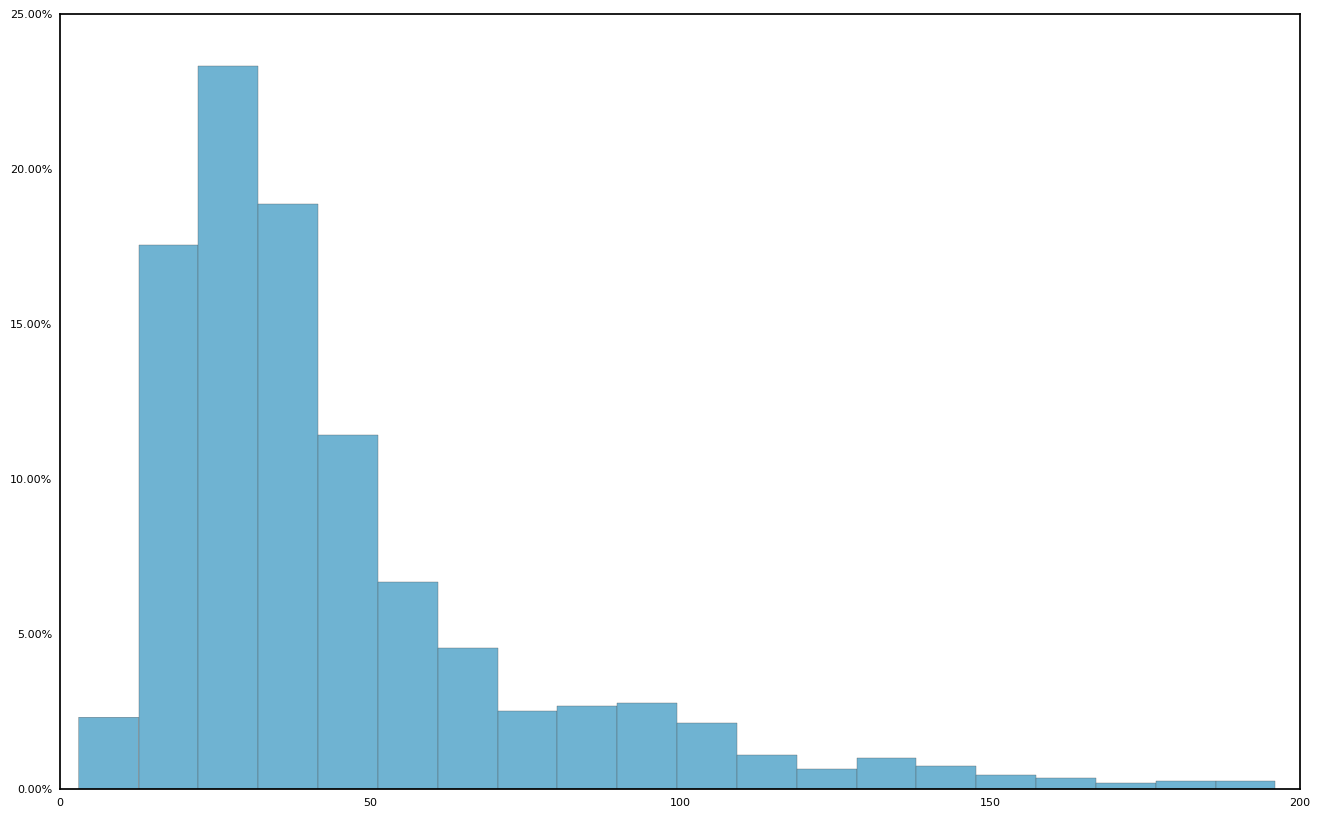

## hide

In [232]:
# for qid, q in sorted(question_asks.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
#     print(q)
# #     print(mc_questions[qid]['answerChoices'])
#     print()

In [161]:
# plt.scatter(xns, yb, color=b16_colors.g, marker = 'o', s=45)
# plt.plot(xns, lin_mod.predict(np.array(xns).reshape(-1,1)), color=b16_colors.b ,alpha=0.8, linewidth=5.0)
# plt.xlim((0,100))
# plt.ylim((0, 1))
# label_color =  b16_colors.b
# plt.title('Ingredient Cooccurrences', fontsize=50, verticalalignment='bottom', color = label_color)
# plt.ylabel("Fraction of pairs extant", fontsize=30, labelpad=15, color = label_color)
# plt.xlabel("Number of shared flavor compounds", fontsize=30, labelpad=10, color = label_color)
# plt.tick_params(axis='x', which='major', labelsize=20)
# plt.tick_params(axis='y', which='major', labelsize=20)

In [519]:
# def tokenize_question(question_text):
#     q_tokens = wordpunct_tokenize(question_text)
#     normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in q_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
#     return normalized_tokens

# def make_and_save_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=b16_colors.b, label_color = '0.25'):
#     if fig_labels:
#         if 'fig_title' in fig_labels:
#             plt.title(fig_labels['fig_title'], fontsize=30, verticalalignment='bottom', color = label_color)
#         if 'y_label' in fig_labels:
#             plt.ylabel(fig_labels['y_label'], fontsize=25, labelpad=10, color = label_color)
#         if 'x_label' in fig_labels:
#             plt.xlabel(fig_labels['x_label'], fontsize=25, labelpad=10, color = label_color)
#     plt.tick_params(axis='x', which='major', labelsize=15)
#     plt.tick_params(axis='y', which='major', labelsize=15)
#     plt.savefig(outfile, bbox_inches='tight')

# def collect_filtered_question_text(question_dict, filter_phrases=None):
#     filtered_questions = {}
#     for phrase in filter_phrases:
#         for qid, question in question_dict.items():
#             question_text = question['beingAsked']['processedText']
#             if phrase in question_text:
#                 filtered_questions[qid] = question_text
#     return filtered_questions

# def make_prop_series(ds_items, property_collector):
#     return(pd.Series([property_collector(item) for item in ds_items.values()]))

# def collect_filtered_lesson_text(complete_ds):
#     filtered_lesson_text = defaultdict(str)
#     for lesson in complete_ds:
#         lesson_key = lesson['lessonName'] + '_' + lesson['globalID']
#         for topic_name, topic in sorted(lesson['topics'].items(), key=lambda x: x[1]['globalID']):
#             if not topic['topicName'] in structural_topics + vocab_topics:
#                 filtered_lesson_text[lesson_key] += topic['content']['text'] 
#     return filtered_lesson_text

# lesson length

In [236]:
lesson_text = collect_filtered_lesson_text(ck12_combined_dataset, True, True)
topic_lengths = pd.Series([len(sent_tokenize(text)) for text in lesson_text.values() if len(sent_tokenize(text)) < 300])

In [350]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)


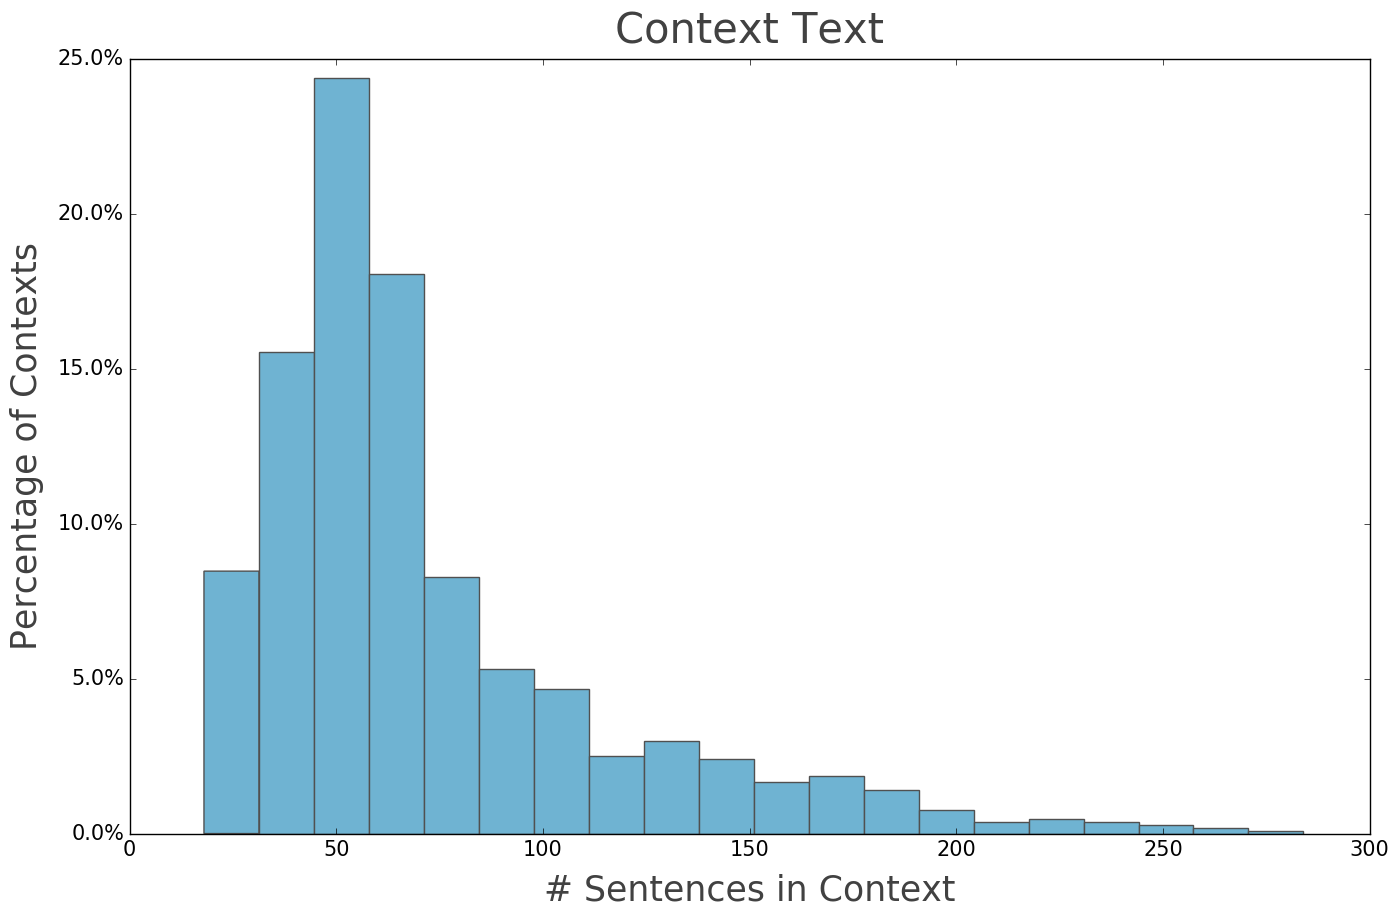

In [422]:
fig_labels = {
    'fig_title': 'Context Text', 
    'x_label': '# Sentences in Context',
    'y_label': 'Percentage of Contexts'
}
weights = np.ones_like(topic_lengths)/len(topic_lengths)
plot_to_save = topic_lengths.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.1f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

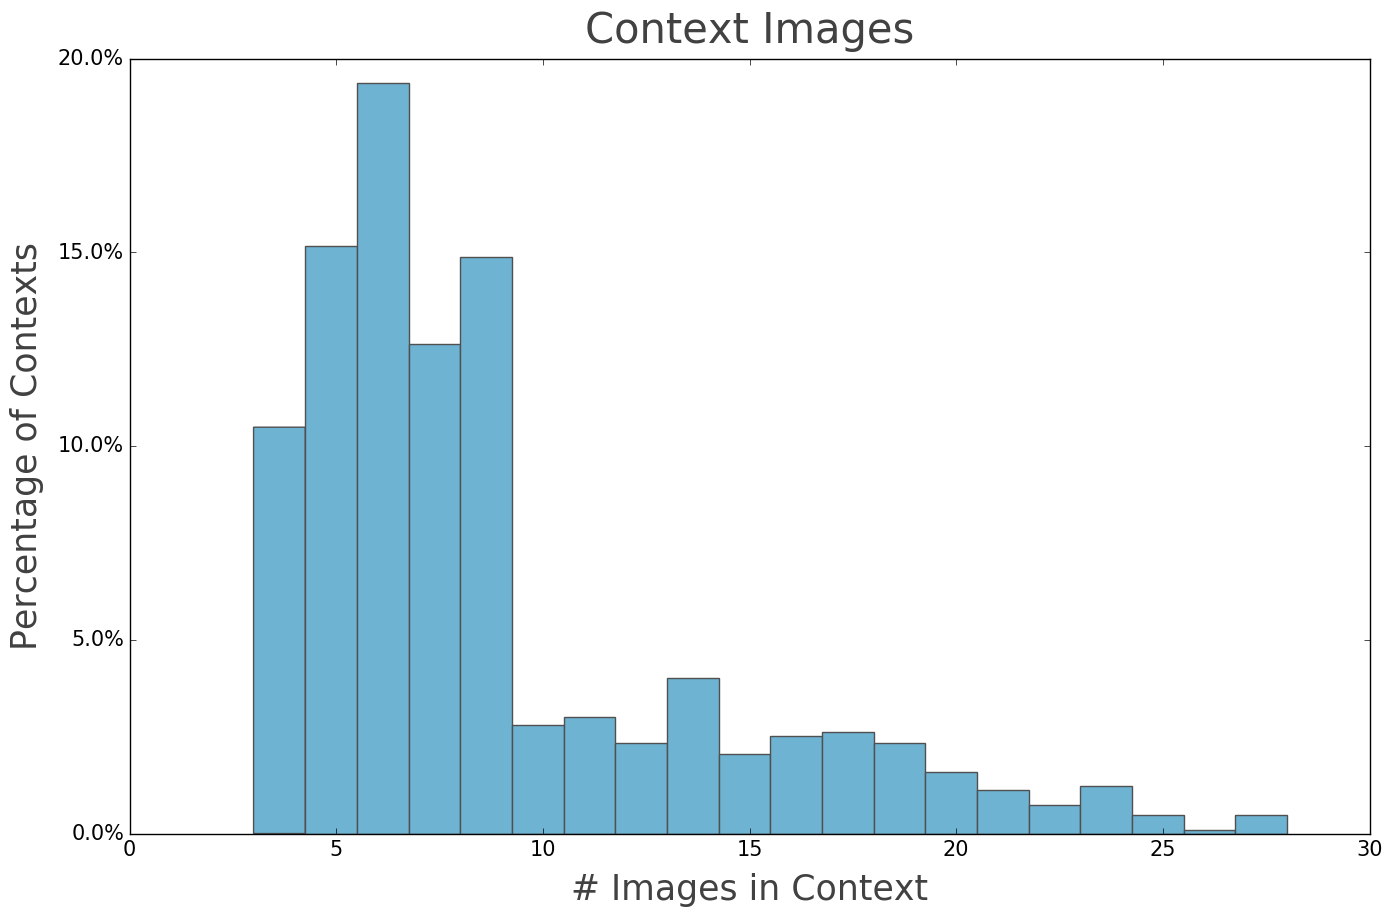

In [423]:
image_number_by_lesson = pd.Series([len(lesson['instructionalDiagrams']) + len([topic['content']['figures'] for topic in extract_topics_and_adjunct_topics(lesson)]) for lesson in ck12_combined_dataset])

fig_labels = {
    'fig_title': 'Context Images', 
    'x_label': '# Images in Context',
    'y_label': 'Percentage of Contexts'
}
image_number_by_lesson = image_number_by_lesson[image_number_by_lesson < 30]
weights = np.ones_like(image_number_by_lesson)/len(image_number_by_lesson)
plot_to_save = image_number_by_lesson.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.1f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [424]:
media_link_number_by_lesson = []
                                              
for lesson in ck12_combined_dataset:
    media_topic_count = 0
    for topic in extract_topics_and_adjunct_topics(lesson):
        media_topic_count += len(topic['content']['mediaLinks'])
    media_link_number_by_lesson.append(media_topic_count)
media_link_number_by_lesson = pd.Series(media_link_number_by_lesson)

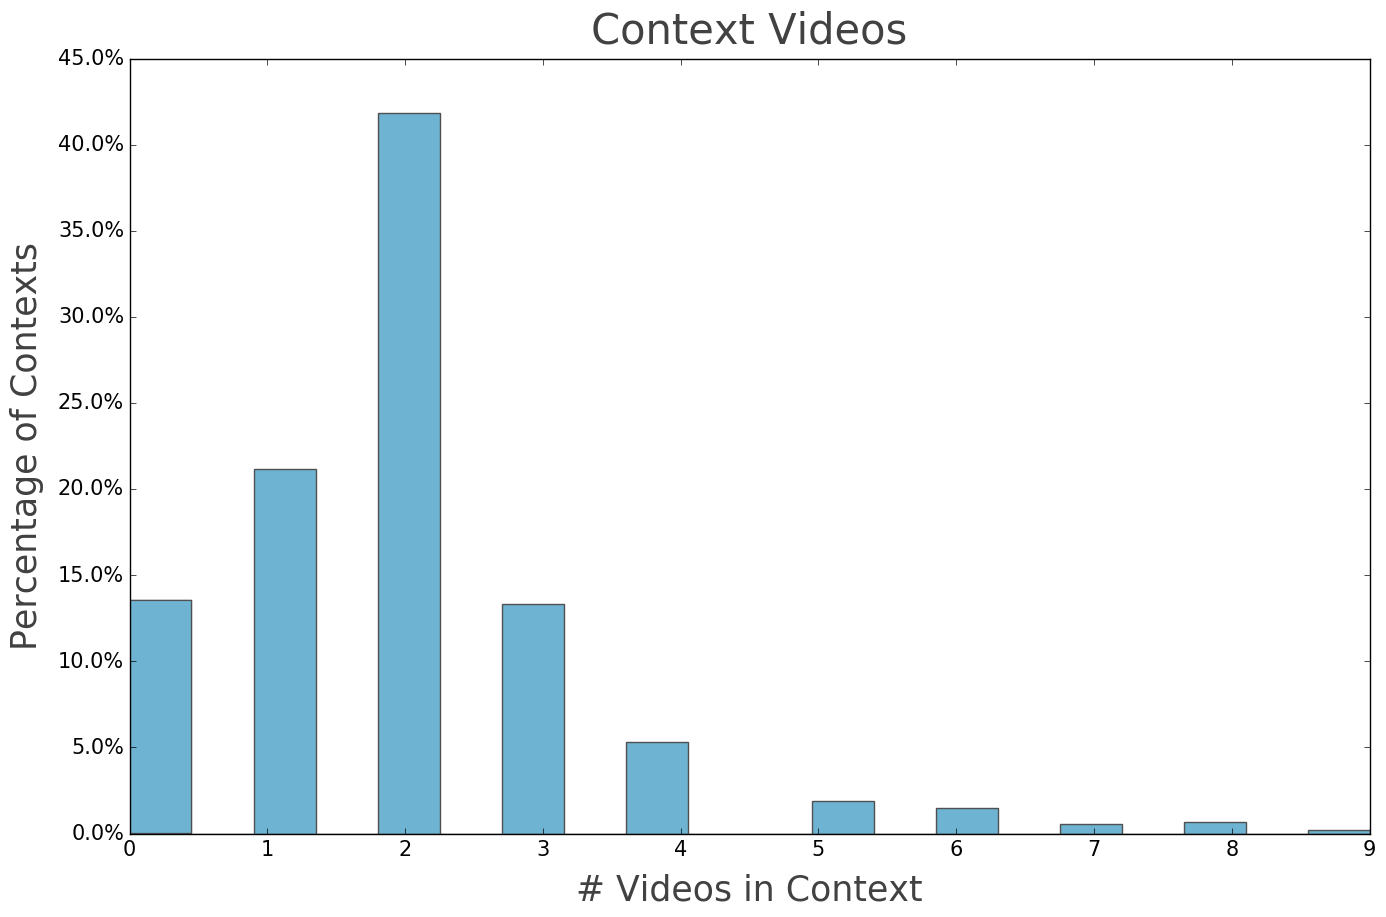

In [425]:
fig_labels = {
    'fig_title': 'Context Videos', 
    'x_label': '# Videos in Context',
    'y_label': 'Percentage of Contexts'
}
media_link_number_by_lesson = media_link_number_by_lesson[media_link_number_by_lesson < 10]
array_to_plot = media_link_number_by_lesson
weights = np.ones_like(array_to_plot)/len(array_to_plot)
plot_to_save = array_to_plot.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.1f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [426]:
# vocab_words_by_lesson = []
                                              
# for lesson in ck12_combined_dataset:
#     vocab_count = 0
#     for sect_name in ['Lesson Vocabulary', 'Vocabulary']:
#         if sect_name in lesson['adjunctTopics'].keys():
#             vocab_count += len(lesson['adjunctTopics'][sect_name])
#     vocab_words_by_lesson.append(vocab_count)
# vocab_words_by_lesson = pd.Series(vocab_words_by_lesson)

# fig_labels = {
#     'fig_title': 'Vocabulary Words', 
#     'x_label': '# Vocabulary Definitions in Context',
#     'y_label': 'Percentage of Context'
# }
# array_to_plot = vocab_words_by_lesson
# weights = np.ones_like(array_to_plot)/len(array_to_plot)
# plot_to_save = array_to_plot.hist(bins= 20, log=False, weights=weights)
# tick_labels = plot_to_save.get_yticks()
# plot_to_save.set_yticklabels(['{:2.1f}%'.format(i*100) for i in tick_labels])

# image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
# make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

# generate question annoations hists

In [416]:
anno_data_dir = './q_anno_results/'

In [299]:
anno_files = !ls './q_anno_results/'

In [300]:
anno_files 

['diagram_question_annoations - ani_sample_diagram_questions.csv',
 'diagram_question_annoations - choi_sample_diagram_questions.csv',
 'diagram_question_annoations - dustin_sample_diagram_questions.csv',
 'question_annotations - ani_sample_questions.csv',
 'question_annotations - choi_sample_questions.csv',
 'question_annotations - dustin_sample_questions.csv']

In [301]:
print(list(qa_df.columns))

['multiple paragraphs', 'single paragraph', 'single sentence', 'external knowledge', 'multiple contexts', 'n1', 'requires diagram', 'lesson_name', 'qid']


In [311]:
cols_new_names = ['multiple paragraphs', 'single paragraph', 'single sentence', 'external knowledge', 'multiple contexts', 'n1', 'requires diagram', 'lesson_name', 'qid']
qa_df.columns = cols_new_names

In [303]:
qa_df_build = pd.read_csv(anno_data_dir + anno_files[3])
qa_df_build = qa_df_build.append(pd.read_csv(anno_data_dir + anno_files[4]))
qa_df_build = qa_df_build.append(pd.read_csv(anno_data_dir + anno_files[5]))
qa_df = qa_df_build.fillna(0)
del qa_df['Weird']
del qa_df['Junk']

In [445]:
dqa_df_build = pd.read_csv(anno_data_dir + anno_files[0])
dqa_df_build = dqa_df_build.append(pd.read_csv(anno_data_dir + anno_files[1]))
dqa_df_build = dqa_df_build.append(pd.read_csv(anno_data_dir + anno_files[2]))
dqa_df = dqa_df_build.fillna(0)

In [319]:
print(list(dqa_df.columns))

['D + 1 image', 'D + 1 image + Lesson (Multi paragraphs)', 'D + 1 para', 'D + External Knowledge', 'D + Lesson (Multi paragraphs)', 'D + Multiple Lessons', 'D-Structure: 1 part', 'D-Structure: Multiple parts', 'D: Global', 'Is OCR enough', 'Nothing to do with D', 'Only D', 'Unnamed: 13', 'lesson_name', 'qid']


In [447]:
dqa_df.head(1)

,D + 1 image,D + 1 image + Lesson (Multi paragraphs),D + 1 para,D + External Knowledge,D + Lesson (Multi paragraphs),D + Multiple Lessons,D-Structure: 1 part,D-Structure: Multiple parts,D: Global,Is OCR enough,Nothing to do with D,Only D,Unnamed: 13,lesson_name,qid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,introduction to plants,DQ_004266


In [495]:
dqa_df.columns = dq_new_cols_to_hist_1[:-2] + dq_new_cols_to_hist_2 + dq_new_cols_to_hist_3 + dq_new_cols_to_hist_1[-2:] + ['Unnamed: 13', 'lesson_name', 'qid']

In [312]:
# cols_to_hist = ['1 lesson', '1 para', '1 sentence', 'External Knowledge', 'Multi-lesson', 'Uses Diagram']
cols_to_hist = ['multiple paragraphs', 'single paragraph', 'single sentence', 'external knowledge', 'multiple contexts', 'requires diagram']

In [494]:
dq_cols_to_hist_1 = ['D + 1 image', 'D + 1 image + Lesson (Multi paragraphs)', 'D + 1 para', 'D + External Knowledge', 'D + Lesson (Multi paragraphs)', 'D + Multiple Lessons']
dq_cols_to_hist_2 = ['D-Structure: 1 part', 'D-Structure: Multiple parts', 'D: Global']
dq_new_cols_to_hist_1 = ['context image', 'image + paragraphs', 'one paragraph', 'external knowledge', 'multiple paragraphs', 'multiple contexts', 'unrelated question', 'only diagram']
dq_new_cols_to_hist_2 = ['single component', 'multiple components', 'all components']
dq_new_cols_to_hist_3 = ['text only sufficent to answer']


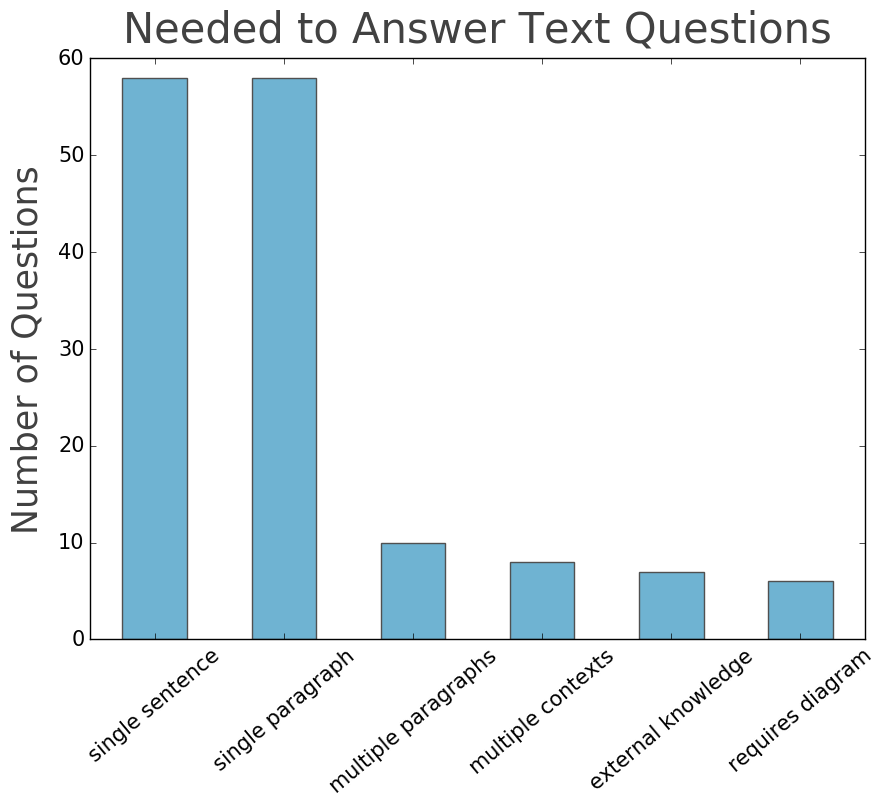

In [540]:
fig_labels = {
    'fig_title': 'Needed to Answer Text Questions', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

# plt.rcParams['figure.figsize'] = (16.0, 10.0)

plot_to_save  = qa_df[cols_to_hist].apply(sum).sort_values(ascending=False).plot(kind='bar')
tick_labels = plot_to_save.get_yticks()
plt.xticks(rotation=40) 

image_filename = fig_dir + 'question_manual_annotation_hist'  + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [481]:
dq_new_cols_to_hist_1

['context image',
 'image + paragraphs',
 'one paragraph',
 'external knowledge',
 'multiple paragraphs',
 'multiple contexts',
 'unrelated question',
 'only diagram']

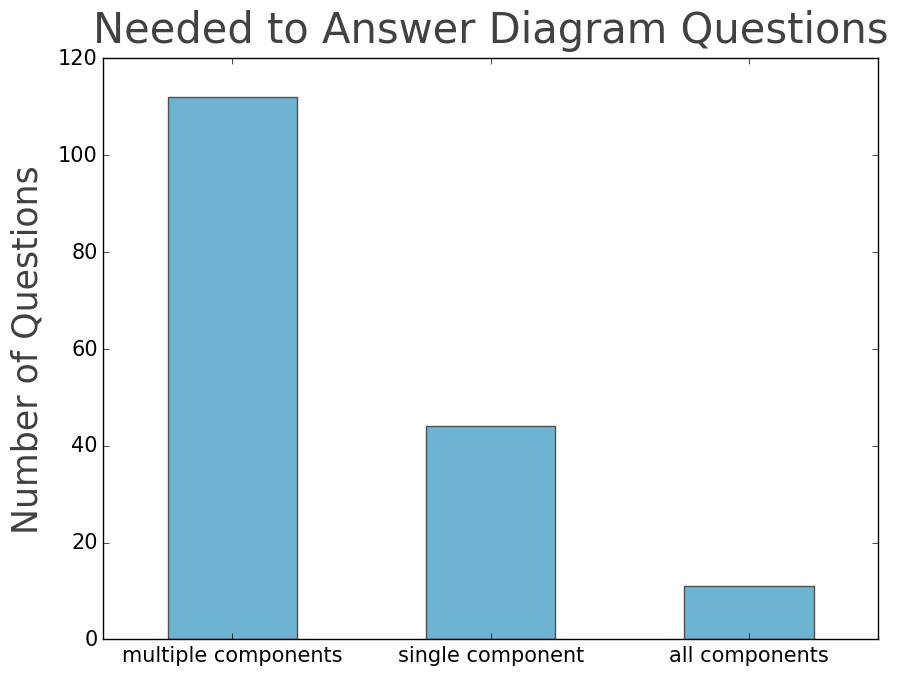

In [535]:
fig_labels = {
    'fig_title': 'Needed to Answer Diagram Questions', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

plt.rcParams['figure.figsize'] = (10.0, 7.5)

plot_to_save  = dqa_df[dq_new_cols_to_hist_2].apply(sum).sort_values(ascending=False).plot(kind='bar')
tick_labels = plot_to_save.get_yticks()
plt.xticks(rotation=0) 
image_filename = fig_dir +  'Diagram Question Annotation Hist 2'.replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

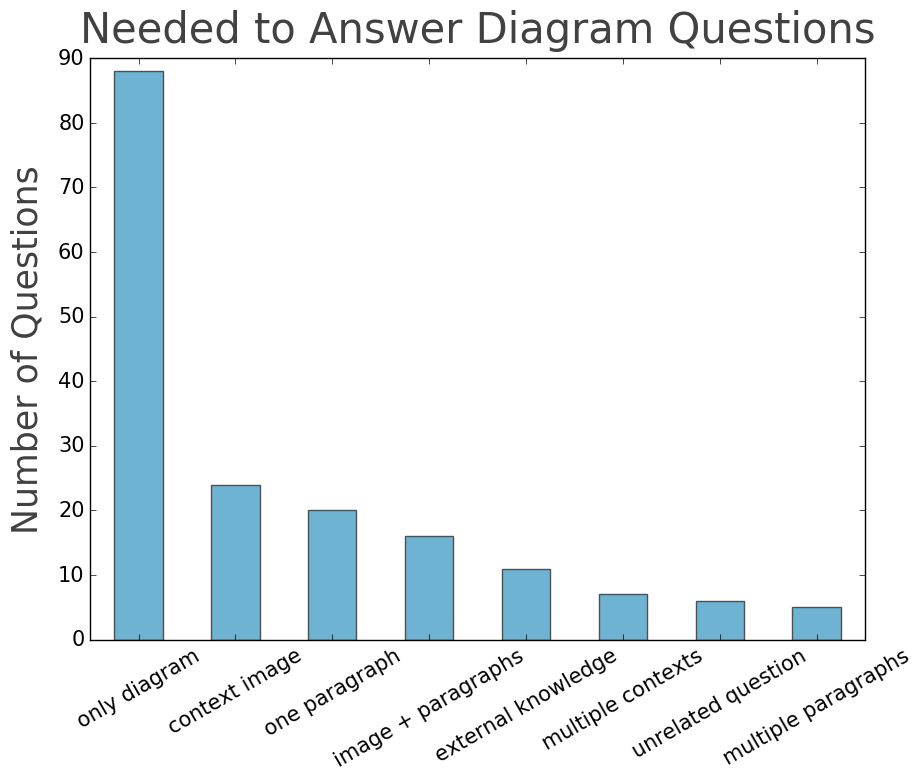

In [537]:
fig_labels = {
    'fig_title': 'Needed to Answer Diagram Questions', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

# plt.rcParams['figure.figsize'] = (10.0, 10.0)

plot_to_save  = dqa_df[dq_new_cols_to_hist_1].apply(sum).sort_values(ascending=False).plot(kind='bar')
tick_labels = plot_to_save.get_yticks()
plt.xticks(rotation=30) 
image_filename = fig_dir +  'Diagram Question Annotation Hist 1'.replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [538]:
dqa_df['text only insufficient to answer'] = dqa_df['text only sufficent to answer'].apply(lambda x: x == 0 )

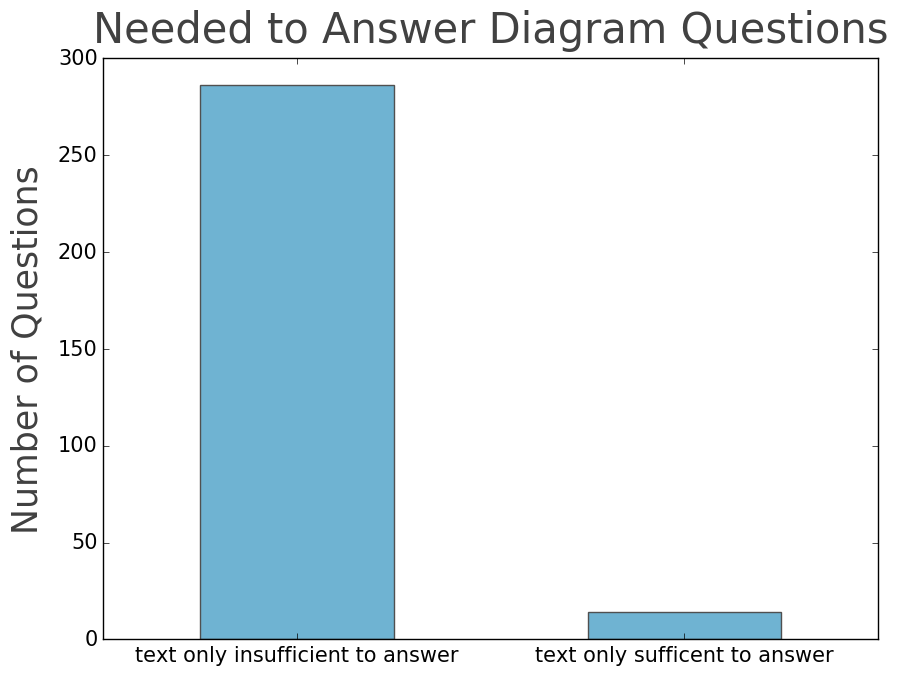

In [539]:
fig_labels = {
    'fig_title': 'Needed to Answer Diagram Questions', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

# plt.rcParams['figure.figsize'] = (10.0, 10.0)

plot_to_save  = dqa_df[dq_new_cols_to_hist_3 + ['text only insufficient to answer']].apply(sum).sort_values(ascending=False).plot(kind='bar')
tick_labels = plot_to_save.get_yticks()
plt.xticks(rotation=0) 
image_filename = fig_dir +  'Diagram Question Annotation Hist 3'.replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [485]:
# fig_labels = {
#     'fig_title': 'Question Annotation Hist', 
#     'x_label': '',
#     'y_label': 'Number of Questions'
# }

# plot_to_save = qa_hist = qa_df[cols_to_hist].apply(sum).sort_values(ascending=False).plot(kind='bar')
# tick_labels = plot_to_save.get_yticks()
# plt.xticks(rotation=40) 

# image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
# make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

# diagram complexity from box number

In [505]:
turk_proc_dir = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/'
metadata_dir = turk_proc_dir + 'store_hit_results_metadata/'
recog_results_dir = 'group_latest_combined'

In [506]:
recog_res_df = pd.read_pickle(os.path.join(metadata_dir, recog_results_dir, 'recog_df.pkl'))

In [508]:
recog_res_df.head(1)

,diagram,rectangle,raw_text,box_diag_idx,hit_id,assignment_id
0,parts_leaf_1091.png,"[[389, 59], [455, 76]]",MIDRIB,0.0,3KL228NDMWMX5HMRVAJSD9OU5V9GKY,34S9DKFK74P1MYQOCV2G1L7M7Q2YN2


In [516]:
recog_res_df['counter'] = 1

In [518]:
grouped_by_diag = recog_res_df.groupby('diagram')
diagram_complexity_series = grouped_by_diag['counter'].aggregate(sum)

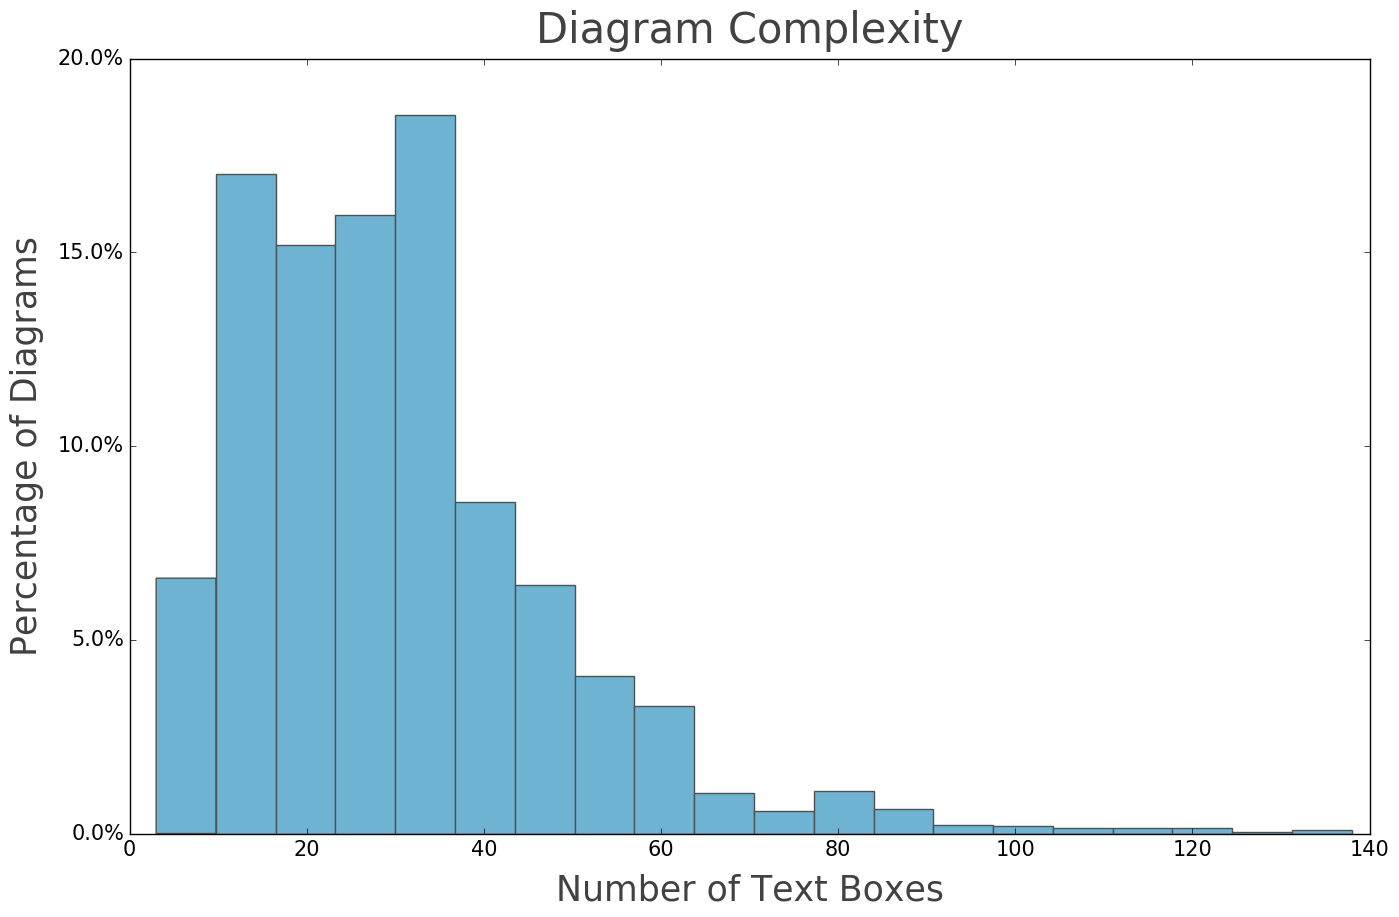

In [541]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)

fig_labels = {
    'fig_title': 'Diagram Complexity', 
    'x_label': 'Number of Text Boxes',
    'y_label': 'Percentage of Diagrams'
}
diagram_complexity_series = diagram_complexity_series[diagram_complexity_series < 150]
array_to_hist = diagram_complexity_series
weights = np.ones_like(array_to_hist)/len(array_to_hist)
plot_to_save = array_to_hist.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.1f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

# hierarchical edge bundling

In [115]:
import random

In [105]:
util_eval = Evaluator(data_file)

In [95]:
with open('./readme-flare-imports.json') as f:
    sample_data =json.load(f)

In [102]:
sample_data[40]

{'imports': ['flare.data.DataField', 'flare.data.DataSchema'],
 'name': 'flare.data.DataUtil',
 'size': 3322}

In [151]:
random_lesson_connections[40]

{'imports': ['train.electronics',
  'test.mechanical_weathering',
  'test.elastic_force'],
 'name': 'train.use_and_conservation_of_resources',
 'size': '300'}

In [126]:
rc = [random.choice(['test']*20 + ['train']*80) for i in range(100)]
sum([c == 'train' for c in rc])

82

In [129]:
all_lessons = [{'lname': lesson['lessonName'], 'tta': random.choice(['test']*20 + ['train']*80)} for lesson in ck12_combined_dataset]

In [185]:
for lesson in all_lessons:
    lesson['importName'] = lesson['tta'] + '.' + lesson['lname'].replace(' ', '_')
random_lesson_sample = [lesson for lesson in all_lessons if random.choice(range(10)) > 8]

In [221]:
random_lesson_connections = []
lessons_to_show = random_lesson_sample
for i in range(len(lessons_to_show)):
    this_lesson = lessons_to_show[i]

    this_entry = {
        'name': this_lesson['importName'],
        'imports': [lesson['importName'] for lesson in random.sample(lessons_to_show, random.randint(1 ,5)) if lesson['importName'].split('.')[0] == this_lesson['importName'].split('.')[0]],
        'size': '300'
    }
    random_lesson_connections.append(this_entry)

In [228]:
len(random_lesson_connections)

124

In [223]:
with open('lesson_connections.json', 'w') as f:
    json.dump(random_lesson_connections, f)

In [342]:
%%HTML
<iframe width="100%" height="500" src="index_ia.html?inline=false"></iframe>

# Generate sample HTML to review

In [967]:
from tqa_utils.render_html import render_sample_question_and_lesson
import random
import gzip

In [834]:
def assign_questions(questions, n):
    for i in rangfe(0, len(questions), n):
        yield questions[i:i + n]

In [968]:
with open('./fn_to_ocrs.pklz', 'rb') as f:
    ocr_results = pickle.load(gzip.open(f))

In [971]:
ocr_results.keys()

dict_keys(['nature_of_earthquakes_20550.png', 'heat_22878.png', 'male_reproductive_system_21502.png', 'kidneys_21943.png', 'characteristics_of_sound_22410.png', 'earth_moon_phases_6003.png', 'erosion_and_deposition_by_flowing_water_20022.png', 'food_chains_webs_443.png', 'food_chains_webs_2069.png', 'rutherfords_atomic_model_23058.png', 'noble_gases_22978.png', 'human_system_eye_6141.png', 'birds_21355.png', 'the_sun_and_the_earthmoon_system_20383.png', 'covalent_bonds_22597.png', 'chemical_weathering_20659.png', 'volcanoes_7671.png', 'neptune_20984.png', 'types_leaves_4408.png', 'parts_cell_3284.png', 'cycle_water_11499.png', 'earth_moon_phases_16006.png', 'faults_1747.png', 'nitrogen_cycle_in_ecosystems_20986.png', 'neutrons_22969.png', 'ocean_waves_19150.png', 'earths_moon_20378.png', 'nuclear_energy_7100.png', 'world_climates_20197.png', 'how_animals_evolved_21295.png', 'radioactive_decay_8180.png', 'earthquake_characteristics_20702.png', 'human_system_eye_6150.png', 'non_mendelian

In [ ]:
result = pickle.load(gzip.open(some_pklz_file))

non diagrams

In [805]:
# random_question_sample = random.sample(list(all_ndqs.values()), 300)
# random_question_dict = {v['globalID']: v for v in random_question_sample}

diagrams

In [893]:
# random_question_sample_diagram = random.sample(list(all_diagram_qs.values()), 300)
# random_diagram_question_dict = {v['globalID']: v for v in random_question_sample_diagram}

In [972]:
# random_assignments = list(assign_questions(list(random_question_dict.keys()), 100))
random_assignments = list(assign_questions(list(random_diagram_question_dict.keys()), 100))

In [973]:
reviewers = ['dustin', 'ani', 'choi']
reviewer_assignments = {reviewers[i]: random_assignments[i] for i in range(len(random_assignments))}
question_reviewer_lookup = {}
for reviewer, qid_list in reviewer_assignments.items():
    for qid in qid_list:
        question_reviewer_lookup[qid] = reviewer

In [985]:
question_sample_with_lessons = {} 
lessons_involved = []
# id_ocr_lookup = {}
#         id_ocr_lookup[qid] = quest_dict[qid]['imageName']

q_type = 'diagramQuestions'
q_not_type = 'nonDiagramQuestions'
# q_type = 'nonDiagramQuestions'
# q_not_type = 'diagramaQuestions'
quest_dict = random_diagram_question_dict
for lesson in ck12_combined_dataset:
    question_sample_in_lesson = [qid for qid in lesson['questions'][q_type].keys() if qid in quest_dict.keys()]
    for qid in question_sample_in_lesson:
        lessons_involved.append(lesson['lessonName'])
        sample_lesson = deepcopy(lesson)
        sample_lesson['questions'][q_not_type] = {}
        question_ocr = ocr_results[id_ocr_lookup[qid]]
        quest_dict[qid]['ocrResults'] = question_ocr
        sample_lesson['questions'][q_type] = {qid: quest_dict[qid]}
        sample_lesson['reviewer'] = question_reviewer_lookup[qid]
        question_sample_with_lessons[qid] = sample_lesson

In [1002]:
bad_qs = []
for q in all_diagram_qs.values():
    if q['correctAnswer']['rawText'].lower() == q['beingAsked']['processedText'].lower():
        bad_qs.append(q['correctAnswer'])

In [1004]:
bad_qs

[{'processedText': 'c',
  'rawText': 'How many periods were during Mesozoic era?'},
 {'processedText': 'd',
  'rawText': 'how many parts of the body are connected to the left kidney?'},
 {'processedText': 'a',
  'rawText': 'How many incomplete circuits are on the picture?'},
 {'processedText': 'b', 'rawText': 'How many parts does the human eye have?'},
 {'processedText': 'c', 'rawText': 'How many livers are in the picture?'},
 {'processedText': 'c', 'rawText': 'How many steps has the hydrologic cycle?'},
 {'processedText': 'd',
  'rawText': 'How many kidneys does the human body have?'}]

In [955]:
len(set(lessons_involved))

248

In [900]:
pd.Series(lessons_involved).value_counts()

introduction to plants                     29
flow of energy                             25
cell structures                            22
the digestive system                       18
insects and other arthropods               15
inside earth                               11
seasons                                    11
evolution and classification of plants     11
the sun and the earthmoon system            9
the nervous system                          7
nuclear energy                              7
the respiratory system                      6
theory of plate tectonics                   6
photosynthesis                              6
cycles of matter                            6
introduction to the solar system            5
vision and the eye                          5
male reproductive system                    4
soils                                       4
types of volcanoes                          4
climate zones and biomes                    4
introduction to the oceans        

In [869]:
# pd.Series(lessons_involved).value_counts()[:10]

In [988]:
for qid, lesson_to_render in question_sample_with_lessons.items():
        out_path = lesson_to_render['reviewer'] + '_sample_diagram_questions' 
        render_sample_question_and_lesson(lesson_to_render, qid, out_path, question_ocr)

In [871]:
# test_html = render_sample_question_and_lesson(test_sample_out[1], 'somepath', 'qid')

In [903]:
qid_df = pd.DataFrame(list(quest_dict.keys()))
qid_df.columns = ['qid']
qid_df['lesson_name'] = qid_df['qid'].apply(lambda x: question_sample_with_lessons[x]['lessonName'])

qid_df['reviwer_file'] = qid_df['qid'].apply(lambda x: question_reviewer_lookup[x] + '_sample_diagram_questions.csv')
# qid_df['reviwer_file'] = qid_df['qid'].apply(lambda x: question_reviewer_lookup[x] + '_sample_questions.csv')

In [905]:
for rev, gdf in qid_df.groupby('reviwer_file'):
     gdf[['qid', 'lesson_name']].to_csv(rev, index=False)

# Templates

In [520]:
fig_labels = {
    'fig_title': '', 
    'x_label': '',
    'y_label': 'Percentage of Questions'
}

array_to_hist = 
weights = np.ones_like(array_to_hist)/len(array_to_hist)
plot_to_save = array_to_hist.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.1}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)